In [1]:
import re
import numpy as np
import collections
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import pandas as pd
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time
import malaya

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
tokenizer = malaya.preprocessing._SocialTokenizer().tokenize
rules_normalizer = malaya.texts._tatabahasa.rules_normalizer

def is_number_regex(s):
    if re.match("^\d+?\.\d+?$", s) is None:
        return s.isdigit()
    return True

def detect_money(word):
    if word[:2] == 'rm' and is_number_regex(word[2:]):
        return True
    else:
        return False

def preprocessing(string):
    tokenized = tokenizer(unidecode(string))
    tokenized = [malaya.stem.naive(w) for w in tokenized]
    tokenized = [w.lower() for w in tokenized if len(w) > 1]
    tokenized = [rules_normalizer.get(w, w) for w in tokenized]
    tokenized = ['<NUM>' if is_number_regex(w) else w for w in tokenized]
    tokenized = ['<MONEY>' if detect_money(w) else w for w in tokenized]
    return tokenized

In [3]:
def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i][:maxlen][::-1]):
            X[i, -1 - no] = dic.get(k, UNK)
    return X

In [4]:
import json

with open('tokenized.json') as fopen:
    dataset = json.load(fopen)
texts = dataset['x']
labels = dataset['y']
del dataset

In [5]:
with open('toxicity-dictionary.json') as fopen:
    dataset = json.load(fopen)
    
dictionary = dataset['dictionary']
rev_dictionary = dataset['reverse_dictionary']

In [6]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta

def Attention(inputs, num_units, num_heads = 8, activation = None):
    inputs = tf.layers.dropout(inputs, 0.3, training=True)
    T_q = T_k = tf.shape(inputs)[1]
    Q_K_V = tf.layers.dense(inputs, 3*num_units, activation)
    Q, K, V = tf.split(Q_K_V, 3, -1)
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), 0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), 0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), 0)
    align = tf.matmul(Q_, K_, transpose_b=True)
    align *= tf.rsqrt(tf.to_float(K_.get_shape()[-1].value))
    paddings = tf.fill(tf.shape(align), float('-inf'))
    lower_tri = tf.ones([T_q, T_k])
    lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()
    masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0],1,1])
    align = tf.where(tf.equal(masks, 0), paddings, align)
    align = tf.nn.softmax(align)
    alignments = tf.transpose(align, [0, 2, 1]) 
    x = tf.matmul(align, V_)
    x = tf.concat(tf.split(x, num_heads, axis=0), 2)
    x += inputs
    x = layer_norm(x)
    return x, alignments

class Model:
    def __init__(self, size_layer, embed_size, dict_size, dimension_output, learning_rate = 1e-3):
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.float32, [None, dimension_output])
        
        encoder_embeddings = tf.Variable(tf.random_uniform([dict_size, embed_size], -1, 1))
        x = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        x += position_encoding(x)
        x = tf.layers.dropout(x, 0.3, training=True) 
        
        x, self.alignments = Attention(x, size_layer)
        self.logits_seq = tf.layers.dense(x, dimension_output)
        self.logits_seq = tf.identity(self.logits_seq, name = 'logits_seq')
        self.logits = self.logits_seq[:,-1]
        self.logits = tf.identity(self.logits, name = 'logits')

        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        correct_prediction = tf.equal(tf.round(tf.nn.sigmoid(self.logits)), tf.round(self.Y))
        all_labels_true = tf.reduce_min(tf.cast(correct_prediction, tf.float32), 1)
        self.accuracy = tf.reduce_mean(all_labels_true)
        self.attention = tf.identity(tf.reduce_mean(self.alignments[0], 1), name = 'alphas')

In [8]:
size_layer = 256
num_layers = 2
dimension_output = len(labels[0])
learning_rate = 1e-4
batch_size = 32
dropout = 0.8
maxlen = 100

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    size_layer,
    len(dictionary),
    dimension_output,
    learning_rate,
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'only-attention/model.ckpt')

'only-attention/model.ckpt'

In [9]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and '_power' not in n.name
    ]
)

In [10]:
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'dense/kernel',
 'dense/bias',
 'gamma',
 'beta',
 'dense_1/kernel',
 'dense_1/bias',
 'logits_seq',
 'logits',
 'alphas']

In [11]:
train_X, test_X, train_Y, test_Y = train_test_split(
    texts, labels, test_size = 0.2
)

In [12]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = str_idx(train_X[i : min(i + batch_size, len(train_X))], dictionary, maxlen)
        batch_y = train_Y[i : min(i + batch_size, len(train_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
        batch_y = test_Y[i : min(i + batch_size, len(test_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1
        
    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1

train minibatch loop:   0%|          | 3/4801 [00:00<03:50, 20.80it/s, accuracy=0.812, cost=0.181] 

epoch: 0, pass acc: 0.000000, current acc: 0.898323
time taken: 241.76166892051697
epoch: 0, training loss: 0.136506, training acc: 0.892439, valid loss: 0.116839, valid acc: 0.898323



train minibatch loop:   0%|          | 3/4801 [00:00<03:50, 20.85it/s, accuracy=0.844, cost=0.136] 

epoch: 1, pass acc: 0.898323, current acc: 0.898948
time taken: 241.37779450416565
epoch: 1, training loss: 0.103845, training acc: 0.900745, valid loss: 0.102865, valid acc: 0.898948



train minibatch loop:   0%|          | 3/4801 [00:00<03:51, 20.72it/s, accuracy=0.844, cost=0.121] 

epoch: 2, pass acc: 0.898948, current acc: 0.899547
time taken: 241.21398639678955
epoch: 2, training loss: 0.095066, training acc: 0.901422, valid loss: 0.097260, valid acc: 0.899547



train minibatch loop:   0%|          | 3/4801 [00:00<03:50, 20.82it/s, accuracy=0.812, cost=0.134] 

epoch: 3, pass acc: 0.899547, current acc: 0.899833
time taken: 241.1545877456665
epoch: 3, training loss: 0.089557, training acc: 0.902200, valid loss: 0.091514, valid acc: 0.899833



train minibatch loop:   0%|          | 3/4801 [00:00<03:50, 20.80it/s, accuracy=0.812, cost=0.121] 

epoch: 4, pass acc: 0.899833, current acc: 0.901213
time taken: 241.13759565353394
epoch: 4, training loss: 0.085141, training acc: 0.902818, valid loss: 0.087218, valid acc: 0.901213



train minibatch loop:   0%|          | 3/4801 [00:00<03:50, 20.86it/s, accuracy=0.844, cost=0.0863]

epoch: 5, pass acc: 0.901213, current acc: 0.901838
time taken: 241.12765336036682
epoch: 5, training loss: 0.080834, training acc: 0.904100, valid loss: 0.083214, valid acc: 0.901838



train minibatch loop:   0%|          | 3/4801 [00:00<03:49, 20.90it/s, accuracy=0.781, cost=0.0845]

epoch: 6, pass acc: 0.901838, current acc: 0.903296
time taken: 240.9689075946808
epoch: 6, training loss: 0.077272, training acc: 0.904784, valid loss: 0.080238, valid acc: 0.903296



train minibatch loop:   0%|          | 3/4801 [00:00<03:50, 20.82it/s, accuracy=0.812, cost=0.0957]

time taken: 241.00552201271057
epoch: 7, training loss: 0.074848, training acc: 0.905487, valid loss: 0.079158, valid acc: 0.903270



train minibatch loop:   0%|          | 3/4801 [00:00<03:50, 20.81it/s, accuracy=0.812, cost=0.129] 

time taken: 240.9566683769226
epoch: 8, training loss: 0.072807, training acc: 0.906307, valid loss: 0.076968, valid acc: 0.903140



test minibatch loop: 100%|██████████| 1201/1201 [00:10<00:00, 116.35it/s, accuracy=1, cost=0.00612]   

time taken: 240.97234177589417
epoch: 9, training loss: 0.071114, training acc: 0.907869, valid loss: 0.075624, valid acc: 0.902671

break epoch:10



In [13]:
saver.save(sess, 'only-attention/model.ckpt')

'only-attention/model.ckpt'

In [14]:
text = preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya, tapi gay bodoh')
new_vector = str_idx([text], dictionary, len(text))
sess.run(tf.nn.sigmoid(model.logits), feed_dict={model.X:new_vector})

array([[0.3315015 , 0.01869684, 0.01216965, 0.0163636 , 0.13262893,
        0.2729065 ]], dtype=float32)

In [15]:
sess.run(tf.nn.sigmoid(model.logits_seq), feed_dict={model.X:new_vector})

array([[[6.0652354e-04, 2.0123320e-03, 3.6770976e-04, 5.6917855e-04,
         5.6679390e-04, 1.6016341e-04],
        [2.3726411e-02, 2.2312617e-03, 4.8197052e-03, 3.8309365e-03,
         1.2273437e-02, 8.0383808e-04],
        [3.0553021e-02, 1.1963643e-03, 6.8286746e-03, 3.5382356e-03,
         1.4238680e-02, 3.3079090e-03],
        [5.4060578e-01, 2.3816165e-02, 1.3812222e-01, 2.4328912e-02,
         2.4560468e-01, 1.7712797e-01],
        [2.5152368e-02, 1.3602711e-02, 1.9648230e-02, 3.0212464e-02,
         3.0157235e-02, 4.1573965e-03],
        [3.1011924e-01, 1.3457464e-02, 5.2210525e-02, 7.1576461e-03,
         7.0590921e-02, 3.2955125e-02],
        [1.4057975e-01, 9.1796927e-03, 2.1016650e-02, 6.6841869e-03,
         6.6434622e-02, 2.4952630e-02],
        [8.5335553e-02, 6.3630124e-03, 6.5950956e-03, 9.5213028e-03,
         1.0843368e-02, 4.7159046e-03],
        [1.4287944e-01, 3.9729971e-02, 1.0572384e-02, 3.2806691e-02,
         4.5657966e-02, 1.2052376e-02],
        [6.8305159e

In [16]:
stack = []
pbar = range(0, len(test_X), batch_size)
for i in pbar:
    batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
    batch_y = test_Y[i : min(i + batch_size, len(test_X))]
    stack.append(sess.run(tf.nn.sigmoid(model.logits),
                         feed_dict = {model.X: batch_x}))

In [17]:
print(metrics.classification_report(np.array(test_Y),np.around(np.concatenate(stack,axis=0)),
                                    target_names=["toxic", "severe_toxic", "obscene", 
                                            "threat", "insult", "identity_hate"]))

               precision    recall  f1-score   support

        toxic       0.80      0.53      0.64      3806
 severe_toxic       0.55      0.17      0.26       417
      obscene       0.80      0.55      0.65      2106
       threat       0.43      0.02      0.05       122
       insult       0.73      0.46      0.56      1989
identity_hate       0.54      0.12      0.20       343

  avg / total       0.76      0.48      0.58      8783



In [18]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [19]:
freeze_graph('only-attention', strings)

INFO:tensorflow:Restoring parameters from only-attention/model.ckpt
INFO:tensorflow:Froze 7 variables.
INFO:tensorflow:Converted 7 variables to const ops.
248 ops in the final graph.


In [20]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [21]:
g = load_graph('only-attention/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits_seq = g.get_tensor_by_name('import/logits_seq:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [23]:
news_string = 'Kerajaan juga perlu prihatin dan peka terhadap nasib para nelayan yang bergantung rezeki sepenuhnya kepada sumber hasil laut. Malah, projek ini memberikan kesan buruk yang berpanjangan kepada alam sekitar selain menjejaskan mata pencarian para nelayan'

In [24]:
text = preprocessing(news_string)
new_vector = str_idx([text], dictionary, len(text))
result = test_sess.run([tf.nn.sigmoid(logits), alphas, tf.nn.sigmoid(logits_seq)], feed_dict = {x: new_vector})

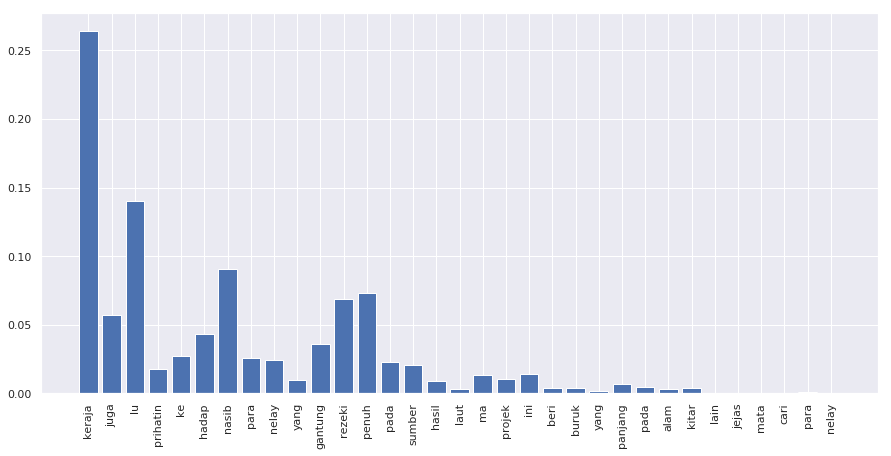

In [25]:
plt.figure(figsize = (15, 7))
labels = [word for word in text]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.show()

In [26]:
result[2]

array([[[1.56210081e-05, 5.89942683e-05, 4.07346088e-05, 5.22144655e-05,
         1.02624954e-05, 4.00837162e-05],
        [6.78369761e-05, 1.05222163e-04, 2.23647614e-04, 1.34143829e-05,
         8.32171863e-05, 5.55181468e-05],
        [2.41727786e-04, 1.97828325e-04, 3.75232834e-04, 1.54550566e-04,
         1.38942763e-04, 2.29237936e-04],
        [1.64956471e-03, 1.18066825e-03, 1.93875027e-03, 2.83026136e-04,
         8.49010539e-04, 1.81022577e-03],
        [5.92637062e-03, 5.57923981e-04, 3.90568003e-03, 1.05292427e-04,
         2.09255447e-03, 2.13713408e-03],
        [1.08235900e-03, 8.31799698e-04, 1.48159685e-03, 1.10484470e-04,
         6.29505666e-04, 6.26944238e-04],
        [9.88643058e-03, 2.57950998e-03, 3.02876648e-03, 1.34259753e-04,
         5.44499699e-03, 1.03080478e-02],
        [6.20629918e-03, 1.57323794e-03, 6.81923795e-03, 1.14800455e-03,
         3.03406431e-03, 2.31336802e-03],
        [6.92411046e-03, 2.50246422e-03, 1.67338492e-03, 6.02958142e-04,
       